In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
from collections import deque
from skimage.feature import hog
from sklearn.cross_validation import train_test_split


In [2]:
objpoints = []
imgpoints = []

objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

pathImages = './camera_cal/'

ListOfImages = os.listdir(pathImages)
img = cv2.imread(pathImages + ListOfImages[0])
image_shape = img.shape
for idx, imagesDistort in enumerate(ListOfImages):
    img = cv2.imread(pathImages + imagesDistort)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        writeName = './output_images/CornersFound' + str(idx) + '.jpg'
        cv2.imwrite(writeName,img)
    else:
        print('Images not processed: ',imagesDistort)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)

Images not processed:  calibration1.jpg
Images not processed:  calibration4.jpg
Images not processed:  calibration5.jpg


In [3]:
def AbsSobelThreshold(gray, SobOrient=1, SobelKernel=3, threshold=(0, 255)):

    if SobOrient == 1:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    elif SobOrient == 2:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    sobel = np.absolute(sobel)
    ScaledSobel = np.uint8(255*sobel/np.max(sobel))
    BinaryOutput = np.zeros_like(ScaledSobel)
    BinaryOutput[(ScaledSobel > threshold[0]) & (ScaledSobel < threshold[1])] = 1
    return BinaryOutput

def GradientMagnitudeThreshold(gray, SobelKernel=3, MagnitudeThreshold=(0, 255)):

    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    sobel = np.sqrt(sobelX ** 2 + sobelY ** 2)
    ScaledSobel = np.uint8(255*sobel/np.max(sobel))
    BinaryOutput = np.zeros_like(ScaledSobel)
    BinaryOutput[(ScaledSobel > MagnitudeThreshold[0]) & (ScaledSobel < MagnitudeThreshold[1])] = 1
    return BinaryOutput

def GradientDirectionThreshold(gray, SobelKernel=3, threshold=(0, np.pi/2)):

    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        ABSGradientDirection = np.absolute(np.arctan(sobelY/sobelX))
        DirectionBinary =  np.zeros_like(ABSGradientDirection)
        DirectionBinary[(ABSGradientDirection > threshold[0]) & (ABSGradientDirection < threshold[1])] = 1
    return DirectionBinary

def RegionOfInterest(img, vertices):

    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def Find3pCircleRadius(x1,y1,x2,y2,x3,y3):
    
    m1 = (y2-y1)/(x2-x1)
    m2 = (y3-y2)/(x3-x2)
    
    xc = (m1*m2*(y1-y3)+m2*(x1+x2)-m1*(x2+x3))/(2*(m2-m1))
    yc = -(xc-(x1+x2)/2)/m1+(y1+y2)/2
    
    Radius = np.sqrt((x2-xc)*(x2-xc)+(y2-yc)*(y2-yc))
    
    return m1, m2, xc, yc, Radius

def PreProcessesOfImages (img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    SChannel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    GradX = AbsSobelThreshold(gray, SobOrient=1, SobelKernel=7, threshold=(10, 255))
    GradY = AbsSobelThreshold(gray, SobOrient=2, SobelKernel=7, threshold=(55, 255))
    MagnitudeBinaryOutput = GradientMagnitudeThreshold(gray, SobelKernel=7, MagnitudeThreshold=(45, 255))
    DirectionBinaryOutput = GradientDirectionThreshold(gray, SobelKernel=7, threshold=(0.65, 1.1))
    CombinedOutput = np.zeros_like(DirectionBinaryOutput)
    CombinedOutput[((GradX == 1) & (GradY == 1)) | ((MagnitudeBinaryOutput == 1) & (DirectionBinaryOutput == 1))] = 1
    SChannelBinary = np.zeros_like(CombinedOutput)
    SChannelBinary[(SChannel > 150) & (SChannel < 255)] = 1
    ColorBinary = np.zeros_like(CombinedOutput)
    ColorBinary[(SChannelBinary > 0) | (CombinedOutput > 0)] = 1
    
   
    return ColorBinary

def HistogramGenerator(img):
    histogram =np.sum(img[img.shape[0]//2:,:], axis=0)
    
    
    return histogram

def HistogramPeakIdentification(histogram):
    peaks = signal.find_peaks_cwt(histogram, np.arange(1,150),min_length=150)
    midpoint = np.int(histogram.shape[0]/2)
    if len(peaks) > 1:
        peak_left, *_, peak_right = peaks
        
    else:
       
        LeftPeaks = np.argmax(histogram[:midpoint])
        RightPeaks = np.argmax(histogram[midpoint:]) + midpoint
    
    return LeftPeaks, RightPeaks

def perspective_transform(img, M):
    warped = cv2.warpPerspective(img, M, dsize = (img.shape[1],img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped

area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]

def PerspectiveOfImage(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    offset1 = 200 
    offset2 = 0 
    offset3 = 0 
    img_size = (gray.shape[1], gray.shape[0])
    src = np.float32(area_of_interest)
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR) 
    return warped, M,Minv

def CreateVideoPreProcess(img):
    OutputCombinedImage = PreProcessesOfImages(img)
    OutputCombinedImage,M,Minv = PerspectiveOfImage(OutputCombinedImage, 9, 6, mtx, dist)
    OutputImage = np.dstack((OutputCombinedImage, OutputCombinedImage, OutputCombinedImage))*255
    histogram = HistogramGenerator(OutputCombinedImage)
    midpoint = np.int(histogram.shape[0]/2)
    LeftXBase = np.argmax(histogram[:midpoint])
    RightXBase = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    WindowHeight = np.int(OutputCombinedImage.shape[0]/nwindows)
    nonzero = OutputCombinedImage.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    LeftXCurrent = LeftXBase
    RightXCurrent = RightXBase
    margin = 80
    minpix = 40
    LeftLaneInds = []
    RightLaneInds = []

    for window in range(nwindows):
        winYLow = OutputCombinedImage.shape[0] - np.int((window+1)*WindowHeight)
        winYHigh = OutputCombinedImage.shape[0] - np.int(window*WindowHeight)
        winXleftLow = LeftXCurrent - margin
        winXleftHigh = LeftXCurrent + margin
        winXrightLow = RightXCurrent - margin
        winXrightHigh = RightXCurrent + margin
        cv2.rectangle(OutputImage,(winXleftLow,winYLow),(winXleftHigh,winYHigh),(0,255,0), 2) 
        cv2.rectangle(OutputImage,(winXrightLow,winYLow),(winXrightHigh,winYHigh),(0,255,0), 2) 
        GoodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (nonzerox < winXleftHigh)).nonzero()[0]
        GoodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (nonzerox < winXrightHigh)).nonzero()[0]
        LeftLaneInds.append(GoodLeftInds)
        RightLaneInds.append(GoodRightInds)
        if len(GoodLeftInds) > minpix:
            LeftXCurrent = np.int(np.mean(nonzerox[GoodLeftInds]))
        if len(GoodRightInds) > minpix:        
            RightXCurrent = np.int(np.mean(nonzerox[GoodRightInds]))

    LeftLaneInds = np.concatenate(LeftLaneInds)
    RightLaneInds = np.concatenate(RightLaneInds)


    leftx = nonzerox[LeftLaneInds]
    lefty = nonzeroy[LeftLaneInds] 
    rightx = nonzerox[RightLaneInds]
    righty = nonzeroy[RightLaneInds] 

    yvals = np.linspace(0, img.shape[0], num=img.shape[0])
    LeftFit = np.polyfit(lefty, leftx, 2)
    LeftFitx = LeftFit[0]*yvals**2 + LeftFit[1]*yvals + LeftFit[2]
    RightFit = np.polyfit(righty, rightx, 2)
    RightFitx = RightFit[0]*yvals**2 + RightFit[1]*yvals + RightFit[2]
    
    
    
    YEval = np.max(yvals)
    
    YEval1 = np.max(yvals)
    YEval2 = np.mean(yvals)
    YEval3 = np.min(yvals)
    LeftFitx_1 = LeftFit[0]*YEval1**2 + LeftFit[1]*yvals + LeftFit[2]
    LeftFitx_2 = LeftFit[0]*YEval2**2 + LeftFit[1]*yvals + LeftFit[2]
    LeftFitx_3 = LeftFit[0]*YEval3**2 + LeftFit[1]*yvals + LeftFit[2]
    RightFitx_1 = RightFit[0]*YEval1**2 + RightFit[1]*yvals + RightFit[2]
    RightFitx_2 = RightFit[0]*YEval2**2 + RightFit[1]*yvals + RightFit[2]
    RightFitx_3 = RightFit[0]*YEval3**2 + RightFit[1]*yvals + RightFit[2]
    
    lm1, lm2, lxc, lyc, lradius = Find3pCircleRadius(LeftFitx_1,YEval1,LeftFitx_2,YEval2,LeftFitx_3,YEval3,)
    LSteeringAngle = 5*360/lxc
    
    rm1, rm2, rxc, ryc, rradius = Find3pCircleRadius(RightFitx_1,YEval1,RightFitx_2,YEval2,RightFitx_3,YEval3,)
     
    RSteeringAngle = 5*360/rxc 
    TotalSterringAngle = LSteeringAngle + RSteeringAngle
    
    LeftFirstValue = LeftFitx[-1]
    RightFirstValue = RightFitx[-1]
    CameraPosition = OutputCombinedImage.shape[1]/2-(LeftFirstValue + RightFirstValue)/2


    
    ymPerPix = 30/720 
    xmPerPix = 3.7 / (RightFirstValue - LeftFirstValue)


    PtsLeft = np.array([np.transpose(np.vstack([LeftFitx, yvals]))])
    PtsRight = np.array([np.flipud(np.transpose(np.vstack([RightFitx, yvals])))])
    pts = np.hstack((PtsLeft, PtsRight))
    
    
    LeftFitCr = np.polyfit(lefty*ymPerPix, leftx*xmPerPix, 2)
    RightFitCr = np.polyfit(righty*ymPerPix, rightx*xmPerPix, 2)
    
    
    LeftCurverad = ((1 + (2*LeftFitCr[0]*YEval*ymPerPix + LeftFitCr[1])**2)**1.5) \
                             /np.absolute(2*LeftFitCr[0])

    RightCurverad = ((1 + (2*RightFitCr[0]*YEval*ymPerPix + RightFitCr[1])**2)**1.5) \
                                /np.absolute(2*RightFitCr[0])
        
    TurningRadius = (LeftCurverad + RightCurverad)/2
    
    warp_zero = np.zeros_like(OutputImage).astype(np.uint8)
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    cv2.polylines(warp_zero, np.array([PtsLeft], dtype=np.int32), False,(255,0,0),thickness = 15)
    cv2.polylines(warp_zero, np.array([PtsRight], dtype=np.int32), False,(0,0,255),thickness = 15)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'Camera Position' + ' [' + str(-CameraPosition*xmPerPix)[:6] + '] m',(10,30), font, 1,(255,255,255),2)
    cv2.putText(img,'Turning Radius ' + ' ['+ str(TurningRadius)[:6] + '] m' ,(10,60), font, 1,(255,255,255),2)
    cv2.putText(img,'Steering Angle ' + '{:.6}'.format(str(TotalSterringAngle)) + '] deg',(10,90), font, 1,(255,255,255),2)
    unwarp = perspective_transform(warp_zero, Minv)
    result = cv2.addWeighted(img, 1, unwarp, 0.3, 0)
    
    return result

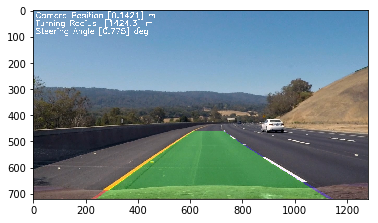

In [4]:
image = mpimg.imread('test_images/test3.jpg')
out_img = CreateVideoPreProcess(image)
plt.imshow(out_img)



In [5]:
images = glob.glob('../testing_CV_set/*/*/*.png')

cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
print('Number of cars: {} '.format(len(cars)))
print('Number of Not Cars: {} '.format(len(notcars)))

Number of cars: 8792 
Number of Not Cars: 8968 


In [6]:

orient = 9
PixPerCell = 8
CellPerBlock = 2
SpatialSize=(32, 32)
HistBins = 32

def BinSpatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def ColorHist(img, nbins=32, BinsRange=(0, 256)):
    channel1Hist = np.histogram(img[:,:,0], bins=nbins, range=BinsRange)
    channel2Hist = np.histogram(img[:,:,1], bins=nbins, range=BinsRange)
    channel3Hist = np.histogram(img[:,:,2], bins=nbins, range=BinsRange)
    HistFeatures = np.concatenate((channel1Hist[0], channel2Hist[0], channel3Hist[0]))
    return HistFeatures

def GetHogFeatures(img, orient, PixPerCell, CellPerBlock, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, HogImage = hog(img, orientations=orient, pixels_per_cell=(PixPerCell, PixPerCell),
                                  cells_per_block=(CellPerBlock, CellPerBlock), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, HogImage
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(PixPerCell, PixPerCell),
                       cells_per_block=(CellPerBlock, CellPerBlock), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def ExtractFeaturesComb(imgs, cspace='RGB', SpatialSize=(32, 32),
                        HistBins=32, HistRange=(0, 256),
                        orient=9, PixPerCell=8, CellPerBlock=2, HogChannel='ALL'):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                FeatureImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                FeatureImage = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                FeatureImage = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                FeatureImage = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: FeatureImage = ConvertColor(image, conv='RGB2YCrCb')    
        SpatialFeatures = BinSpatial(FeatureImage, size=SpatialSize)
        HistFeatures = ColorHist(FeatureImage, nbins=HistBins, BinsRange=HistRange)
        if HogChannel == 'ALL':
            HogFeatures = []
            for channel in range(FeatureImage.shape[2]):
                HogFeatures.append(GetHogFeatures(FeatureImage[:,:,channel], 
                                    orient, PixPerCell, CellPerBlock, 
                                    vis=False, feature_vec=True))
            HogFeatures = np.ravel(HogFeatures)        
        else:
            HogFeatures = GetHogFeatures(FeatureImage[:,:,HogChannel], orient, 
                        PixPerCell, CellPerBlock, vis=False, feature_vec=True)
        features.append(np.concatenate((SpatialFeatures, HistFeatures, HogFeatures)))
    return features

def ConvertColor(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

spatial = 32
histbin = 32

CarFeatures = ExtractFeaturesComb(cars, cspace='RGB', SpatialSize=(spatial, spatial),
                        HistBins=histbin, HistRange=(0, 256))
NotcarFeatures = ExtractFeaturesComb(notcars, cspace='RGB', SpatialSize=(spatial, spatial),
                        HistBins=histbin, HistRange=(0, 256))

X = np.vstack((CarFeatures, NotcarFeatures)).astype(np.float64)                        
XScaler = StandardScaler().fit(X)
ScaledX = XScaler.transform(X)
y = np.hstack((np.ones(len(CarFeatures)), np.zeros(len(NotcarFeatures))))

RandState = np.random.randint(0, 100)
XTrain, XTest, YTrain, YTest = train_test_split(ScaledX, y, test_size=0.2, random_state=RandState)

svc = LinearSVC()
svc.fit(XTrain, YTrain)

print('-------------------Parameter Selection Process--------------------')
print('SVC (C-Support Vector) Parameters')
print('')
print('Pixels per cell: ' + str(PixPerCell))
print('Cells per block: ' + str(CellPerBlock))
print('Orientation: ' + str(orient))
print('-------------------------------------------------------------------')
print('SVM Test Accuracy = ', round(svc.score(XTest, YTest), 4))

-------------------Parameter Selection Process--------------------
SVC (C-Support Vector) Parameters

Pixels per cell: 8
Cells per block: 2
Orientation: 9
-------------------------------------------------------------------
SVM Test Accuracy =  0.9873


In [7]:
ystart = 400
ystop = 656
scale = 1.5


def DrawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


def FindCars(img, ystart, ystop, scale, svc, XScaler, orient, PixPerCell, CellPerBlock, SpatialSize, HistBins):
    DrawImg = np.copy(img)
    img = img.astype(np.float32)/255
    
    ImgToSearch = img[ystart:ystop,:,:]
    CtransToSearch = ConvertColor(ImgToSearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = CtransToSearch.shape
        CtransToSearch = cv2.resize(CtransToSearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = CtransToSearch[:,:,0]
    ch2 = CtransToSearch[:,:,1]
    ch3 = CtransToSearch[:,:,2]

    nxblocks = (ch1.shape[1] // PixPerCell)-1
    nyblocks = (ch1.shape[0] // PixPerCell)-1 
    NfeatPerBlock = orient*CellPerBlock**2
    window = 64
    NBlocksPerWindow = (window // PixPerCell)-1 
    CellsPerStep = 2  
    nxsteps = (nxblocks - NBlocksPerWindow) // CellsPerStep
    nysteps = (nyblocks - NBlocksPerWindow) // CellsPerStep
    hog1 = GetHogFeatures(ch1, orient, PixPerCell, CellPerBlock, feature_vec=False)
    hog2 = GetHogFeatures(ch2, orient, PixPerCell, CellPerBlock, feature_vec=False)
    hog3 = GetHogFeatures(ch3, orient, PixPerCell, CellPerBlock, feature_vec=False)
    
    Bboxes = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*CellsPerStep
            xpos = xb*CellsPerStep
            HogFeat1 = hog1[ypos:ypos+NBlocksPerWindow, xpos:xpos+NBlocksPerWindow].ravel() 
            HogFeat2 = hog2[ypos:ypos+NBlocksPerWindow, xpos:xpos+NBlocksPerWindow].ravel() 
            HogFeat3 = hog3[ypos:ypos+NBlocksPerWindow, xpos:xpos+NBlocksPerWindow].ravel() 
            HogFeatures = np.hstack((HogFeat1, HogFeat2, HogFeat3))
            xleft = xpos*PixPerCell
            ytop = ypos*PixPerCell
            subimg = cv2.resize(CtransToSearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            SpatialFeatures = BinSpatial(subimg, size=SpatialSize)
            HistFeatures = ColorHist(subimg, nbins=HistBins)
            TestFeatures = XScaler.transform(np.hstack((SpatialFeatures, HistFeatures, HogFeatures)).reshape(1, -1))      
            TestPrediction = svc.predict(TestFeatures)
            
            if TestPrediction == 1:
                XboxLeft = np.int(xleft*scale)
                YtopDraw = np.int(ytop*scale)
                WinDraw = np.int(window*scale)
                Bboxes.append(((XboxLeft, YtopDraw+ystart),(XboxLeft+WinDraw,YtopDraw+WinDraw+ystart)))
                
    return Bboxes

def AddHeat(heatmap, BboxList):
    for box in BboxList:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def ApplyThreshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def DrawLabeledBboxes(img, labels):
    for CarNumber in range(1, labels[1]+1):
        nonzero = (labels[0] == CarNumber).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def AddHeatVideos(heatmap, BboxesDeque):
    for BboxList in BboxesDeque:
        for box in BboxList:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [8]:
def PipelineVideoCreation(img):
    OutImg = CreateVideoPreProcess(img)
    Bboxes = FindCars(OutImg, ystart, ystop, scale, svc, XScaler, orient, PixPerCell, CellPerBlock, SpatialSize, HistBins)
    BboxesDeque.append(Bboxes)
    heat = np.zeros_like(OutImg[:,:,0]).astype(np.float)
    AddHeatVideos(heat, BboxesDeque)
    heat = ApplyThreshold(heat,18)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    DrawImg = DrawLabeledBboxes(np.copy(OutImg), labels)
    return DrawImg



True

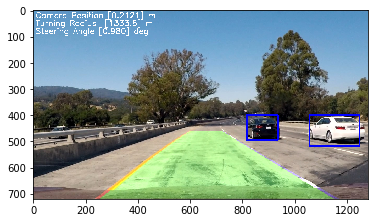

In [9]:
from collections import deque
BboxesDeque = deque(maxlen=30)
image = mpimg.imread('test_images/test1.jpg')
DrawImg = PipelineVideoCreation(image)
plt.imshow(DrawImg)
writeName = './output_images/VehicleDetection.jpg'
cv2.imwrite(writeName,DrawImg)

In [ ]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(PipelineVideoCreation)
%time output_clip.write_videofile(output, audio=False)